In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 37.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from torch.nn.modules import activation
from time import perf_counter
import random
import pandas
import statistics
import csv

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'LRP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"
normalize_coeff = 100
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [5]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2, num_hid_layers=2, Bias=classifier_bias, act_fun='eLu', Weight_Initializer=1, dropout_rate=classifier_dropout)

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.


In [6]:
#dataset = SynGraphDataset('./datasets', 'BA_shapes')
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
#dataset = GINDataset('MUTAG', self_loop=False)


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [7]:
print("Number of Graphs: ", len(dataset))
print("Number of Node Features: ", dataset.num_node_features)
print("Number of Edge Features: ", dataset.num_edge_features)
#print("Number of Node Features: ", dataset.num_node_attributes)
#print("Number of Node Features: ", dataset.num_edge_attributes)
print("Number of Classes: ", dataset.num_classes)
count=0
for i in range(len(dataset)):
  count = count + len(dataset[i].edge_index[0])
print("Number of Edges: ", count)
data = dataset[0]
print(data)
#print(dataset.labels)

Number of Graphs:  188
Number of Node Features:  7
Number of Edge Features:  4
Number of Classes:  2
Number of Edges:  7442
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [8]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
  read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
  read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [9]:
#torch.manual_seed(123456)

#train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, random_state=0, shuffle=True)
#train_dataset = dataset[:150]
#test_dataset = dataset[150:]

train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38
Number of training graphs: 150
Number of test graphs: 38


In [10]:
print("Number of Training Graphs: ", len(train_dataset))
print("Number of Test Graphs: ", len(test_dataset))

count=0
for i in range(len(train_dataset)):
    count = count + len(train_dataset[i].edge_index[0])
print("Number of Edges in TrainingSet: ", count)
count=0
for i in range(len(test_dataset)):
    count = count + len(test_dataset[i].edge_index[0])
print("Number of Edges in TestSet: ", count)

Number of Training Graphs:  150
Number of Test Graphs:  38
Number of Edges in TrainingSet:  6064
Number of Edges in TestSet:  1378


In [11]:
g = train_dataset[0]
print(g.y)

tensor([1])


## **Batching Data by DataLoader**

In [12]:
from torch_geometric.loader import DataLoader
BATCH_SIZE = 64

torch.manual_seed(123456)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
print(train_dataset[0])
#print(train_dataset[0][0])
#print(train_dataset[0][0])
print(train_dataset[0])
######print(GCN_Model(dataset[0].x, dataset[0].edge_index))

Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])
Data(edge_index=[2, 60], x=[26, 7], edge_attr=[60, 4], y=[1])


In [14]:
print(train_loader.batch_size)
batch = next(iter(train_loader))
print(batch.y)
print(len(train_loader))

64
tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])
3


In [15]:
for batch in train_loader:
    print(batch.y)

tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1])


In [16]:
feat_size = train_dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


In [17]:
GNN_Model_Optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [18]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [19]:
def loading_model(load_index):
    GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                           num_hid_layers=2, Bias=classifier_bias, act_fun='eLu', Weight_Initializer=1,
                                           dropout_rate=classifier_dropout)
    GNN_Model_Optimizer = torch.optim.Adam(params = GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")
    GNN_Model.load_state_dict(checkpoint['model_state_dict'])
    GNN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return GNN_Model, GNN_Model_Optimizer, epoch

In [20]:
def visualize_losses(gcn_losses, epoch_history):
    gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("`GCN Model Loss in Epoch: " + str(epoch_history))
    ax.plot(gcn_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/' + str(Explainability_name) + ' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

# **Traning Configurations**

In [21]:
def train_step():
    GNN_Model_loss_batch = []
    LRP_Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batch_of_graphs in train_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        pred = soft.argmax(dim=1)
        LRP_Pred_Labels.extend(pred.detach().tolist())
        Real_Labels.extend(batch_of_graphs.y.detach().tolist())

        batch_loss = loss_calculations(soft, batch_of_graphs.y)
        GNN_Model_loss_batch.append(batch_loss)

        batch_loss.backward()
        GNN_Model_Optimizer.step()

    return torch.mean(torch.tensor(GNN_Model_loss_batch)), metrics.accuracy_score(Real_Labels, LRP_Pred_Labels)

In [22]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [23]:
LRP_Model_training_time_per_epoch = []
LRP_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
    GNN_Model_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        start_generation = perf_counter()
        GNN_Model_training_loss, training_acc = train_step()
        LRP_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        LRP_Model_training_Acc_per_epoch.append(training_acc)
        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GNN_Model_training_loss:.4f}')

        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)

        #break

        if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")


    #return model_loss




Epoch: 001, LRP Model Loss: 0.6905
Epoch: 002, LRP Model Loss: 0.6884
Epoch: 003, LRP Model Loss: 0.6818
Epoch: 004, LRP Model Loss: 0.6772
Epoch: 005, LRP Model Loss: 0.6746
Epoch: 006, LRP Model Loss: 0.6728
Epoch: 007, LRP Model Loss: 0.6636
Epoch: 008, LRP Model Loss: 0.6659
Epoch: 009, LRP Model Loss: 0.6513
Epoch: 010, LRP Model Loss: 0.6520
Epoch: 011, LRP Model Loss: 0.6562
Epoch: 012, LRP Model Loss: 0.6480
Epoch: 013, LRP Model Loss: 0.6461
Epoch: 014, LRP Model Loss: 0.6508
Epoch: 015, LRP Model Loss: 0.6579
Epoch: 016, LRP Model Loss: 0.6405
Epoch: 017, LRP Model Loss: 0.6387
Epoch: 018, LRP Model Loss: 0.6335
Epoch: 019, LRP Model Loss: 0.6522
Epoch: 020, LRP Model Loss: 0.6250
Epoch: 021, LRP Model Loss: 0.6370
Epoch: 022, LRP Model Loss: 0.6249
Epoch: 023, LRP Model Loss: 0.6169
Epoch: 024, LRP Model Loss: 0.6397
Epoch: 025, LRP Model Loss: 0.6285
Epoch: 026, LRP Model Loss: 0.6528
Epoch: 027, LRP Model Loss: 0.6274
Epoch: 028, LRP Model Loss: 0.6373
Epoch: 029, LRP Mode

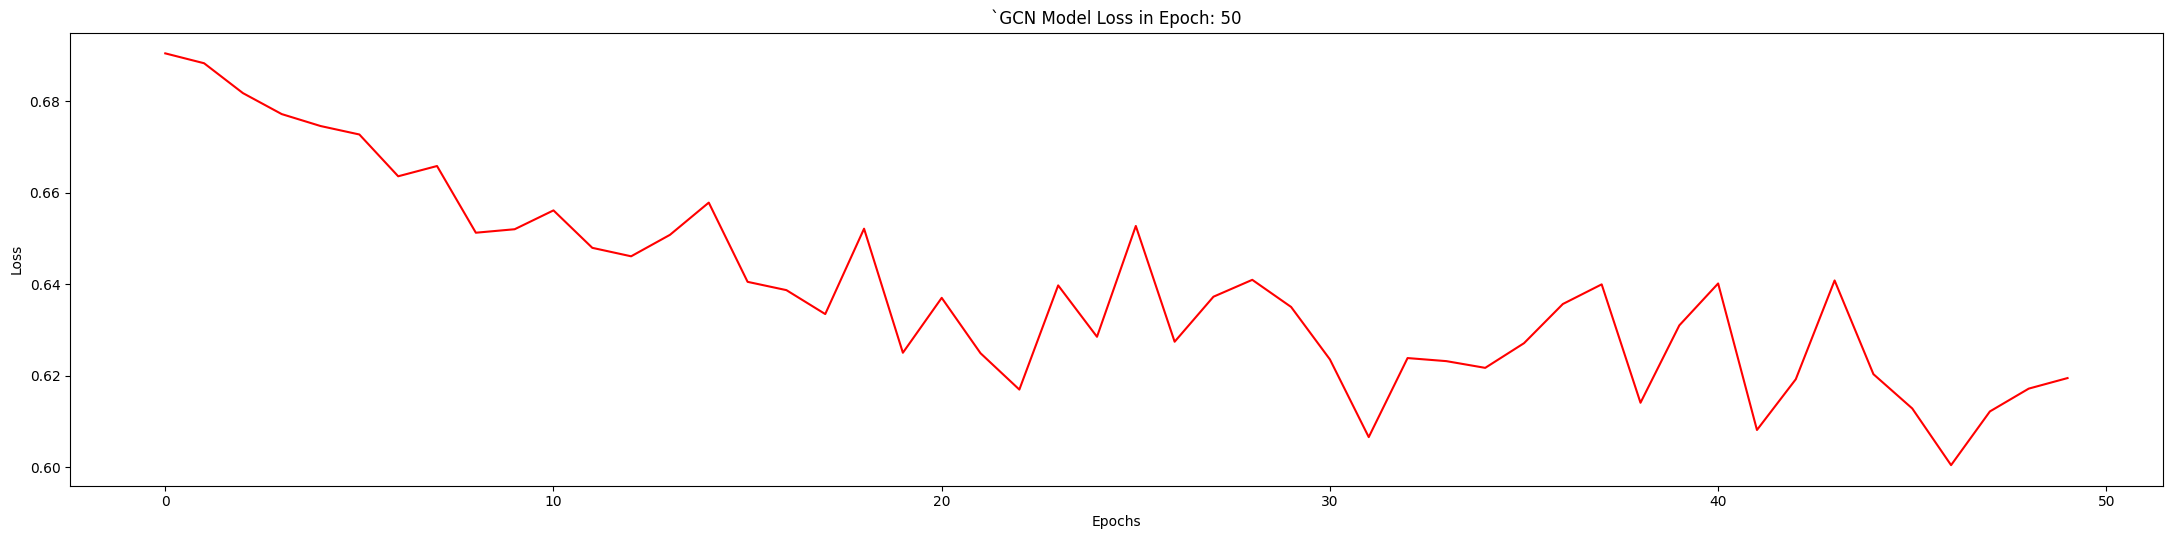

Epoch: 051, LRP Model Loss: 0.6309
Epoch: 052, LRP Model Loss: 0.6329
Epoch: 053, LRP Model Loss: 0.6194
Epoch: 054, LRP Model Loss: 0.6126
Epoch: 055, LRP Model Loss: 0.6183
Epoch: 056, LRP Model Loss: 0.6253
Epoch: 057, LRP Model Loss: 0.6387
Epoch: 058, LRP Model Loss: 0.6250
Epoch: 059, LRP Model Loss: 0.6169
Epoch: 060, LRP Model Loss: 0.6299
Epoch: 061, LRP Model Loss: 0.6150
Epoch: 062, LRP Model Loss: 0.6039
Epoch: 063, LRP Model Loss: 0.6230
Epoch: 064, LRP Model Loss: 0.6494
Epoch: 065, LRP Model Loss: 0.6297
Epoch: 066, LRP Model Loss: 0.6041
Epoch: 067, LRP Model Loss: 0.6287
Epoch: 068, LRP Model Loss: 0.6504
Epoch: 069, LRP Model Loss: 0.6160
Epoch: 070, LRP Model Loss: 0.6224
Epoch: 071, LRP Model Loss: 0.6341
Epoch: 072, LRP Model Loss: 0.6294
Epoch: 073, LRP Model Loss: 0.6241
Epoch: 074, LRP Model Loss: 0.6346
Epoch: 075, LRP Model Loss: 0.6358
Epoch: 076, LRP Model Loss: 0.6254
Epoch: 077, LRP Model Loss: 0.6274
Epoch: 078, LRP Model Loss: 0.6100
Epoch: 079, LRP Mode

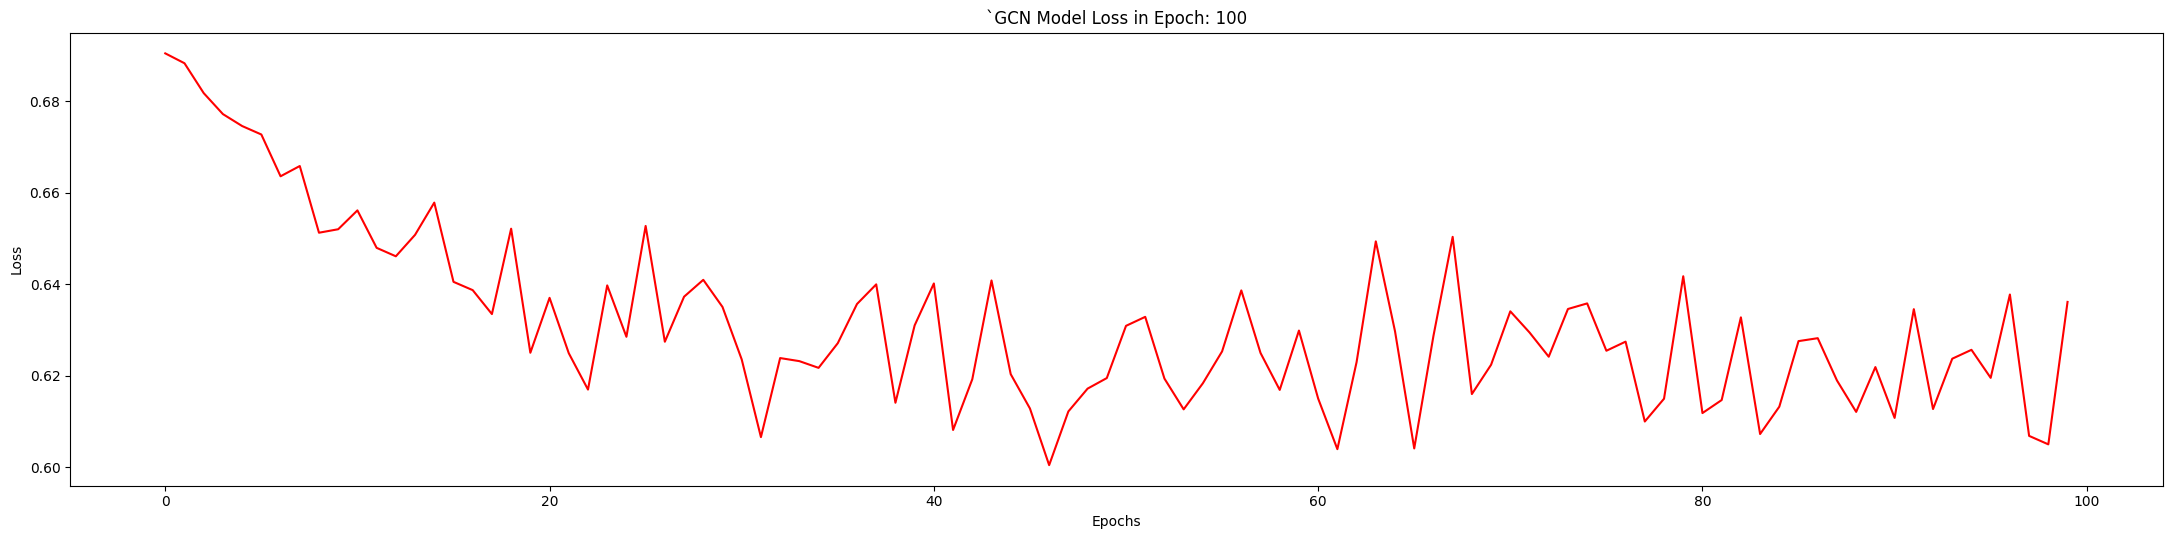

Epoch: 101, LRP Model Loss: 0.6185
Epoch: 102, LRP Model Loss: 0.6184
Epoch: 103, LRP Model Loss: 0.6033
Epoch: 104, LRP Model Loss: 0.6074
Epoch: 105, LRP Model Loss: 0.6234
Epoch: 106, LRP Model Loss: 0.6206
Epoch: 107, LRP Model Loss: 0.6192
Epoch: 108, LRP Model Loss: 0.6192
Epoch: 109, LRP Model Loss: 0.6164
Epoch: 110, LRP Model Loss: 0.6337
Epoch: 111, LRP Model Loss: 0.6284
Epoch: 112, LRP Model Loss: 0.6022
Epoch: 113, LRP Model Loss: 0.6167
Epoch: 114, LRP Model Loss: 0.6244
Epoch: 115, LRP Model Loss: 0.6132
Epoch: 116, LRP Model Loss: 0.6139
Epoch: 117, LRP Model Loss: 0.6121
Epoch: 118, LRP Model Loss: 0.6142
Epoch: 119, LRP Model Loss: 0.6081
Epoch: 120, LRP Model Loss: 0.6071
Epoch: 121, LRP Model Loss: 0.5994
Epoch: 122, LRP Model Loss: 0.6183
Epoch: 123, LRP Model Loss: 0.5913
Epoch: 124, LRP Model Loss: 0.6159
Epoch: 125, LRP Model Loss: 0.5973
Epoch: 126, LRP Model Loss: 0.6045
Epoch: 127, LRP Model Loss: 0.6035
Epoch: 128, LRP Model Loss: 0.6108
Epoch: 129, LRP Mode

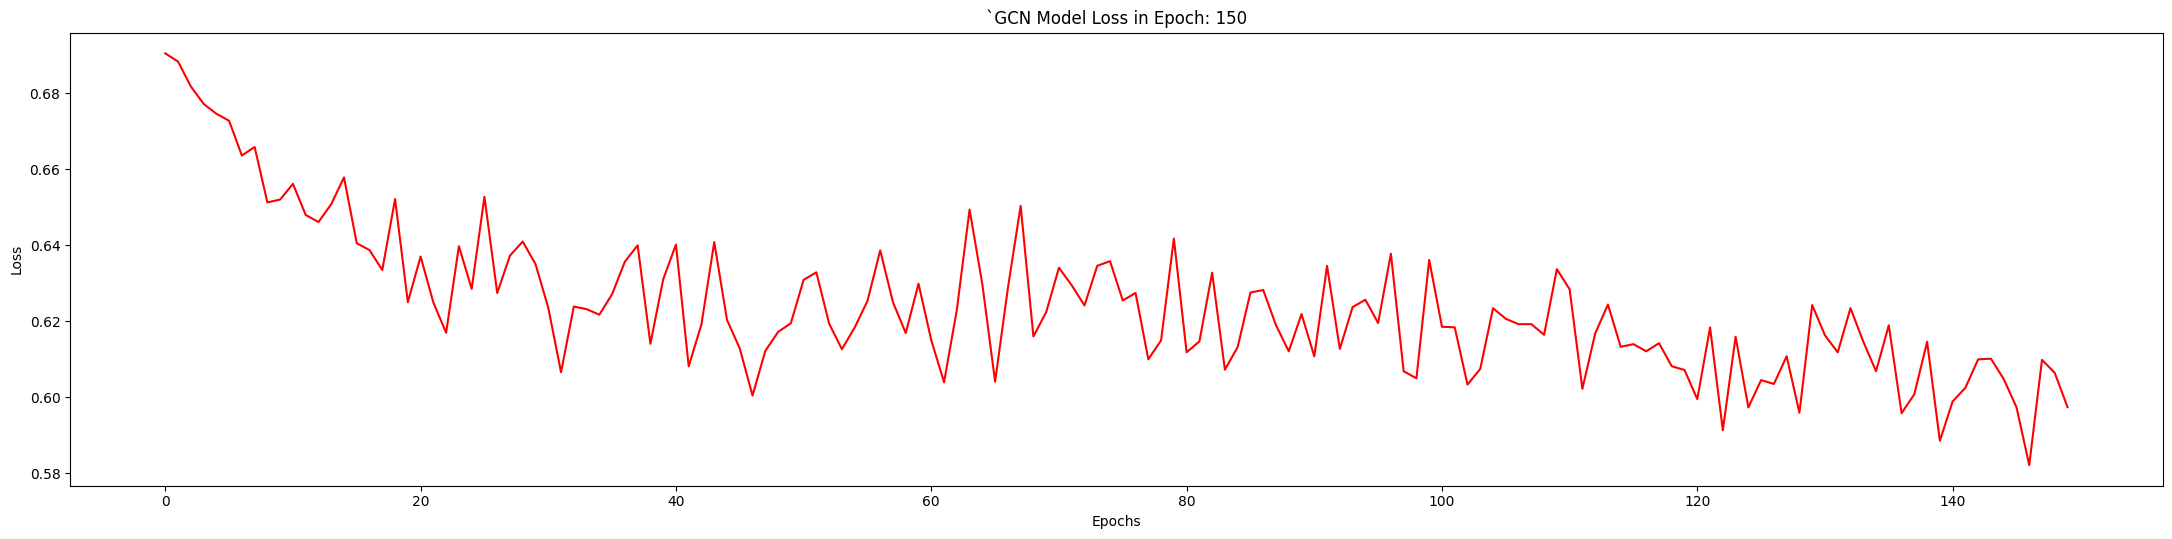

Epoch: 151, LRP Model Loss: 0.6094
Epoch: 152, LRP Model Loss: 0.6018
Epoch: 153, LRP Model Loss: 0.6088
Epoch: 154, LRP Model Loss: 0.5941
Epoch: 155, LRP Model Loss: 0.5992
Epoch: 156, LRP Model Loss: 0.5803
Epoch: 157, LRP Model Loss: 0.5937
Epoch: 158, LRP Model Loss: 0.5738
Epoch: 159, LRP Model Loss: 0.5852
Epoch: 160, LRP Model Loss: 0.5814
Epoch: 161, LRP Model Loss: 0.5818
Epoch: 162, LRP Model Loss: 0.5724
Epoch: 163, LRP Model Loss: 0.5888
Epoch: 164, LRP Model Loss: 0.5971
Epoch: 165, LRP Model Loss: 0.5916
Epoch: 166, LRP Model Loss: 0.5797
Epoch: 167, LRP Model Loss: 0.5615
Epoch: 168, LRP Model Loss: 0.5830
Epoch: 169, LRP Model Loss: 0.5784
Epoch: 170, LRP Model Loss: 0.5775
Epoch: 171, LRP Model Loss: 0.5791
Epoch: 172, LRP Model Loss: 0.5637
Epoch: 173, LRP Model Loss: 0.5858
Epoch: 174, LRP Model Loss: 0.5652
Epoch: 175, LRP Model Loss: 0.5785
Epoch: 176, LRP Model Loss: 0.5865
Epoch: 177, LRP Model Loss: 0.5750
Epoch: 178, LRP Model Loss: 0.5770
Epoch: 179, LRP Mode

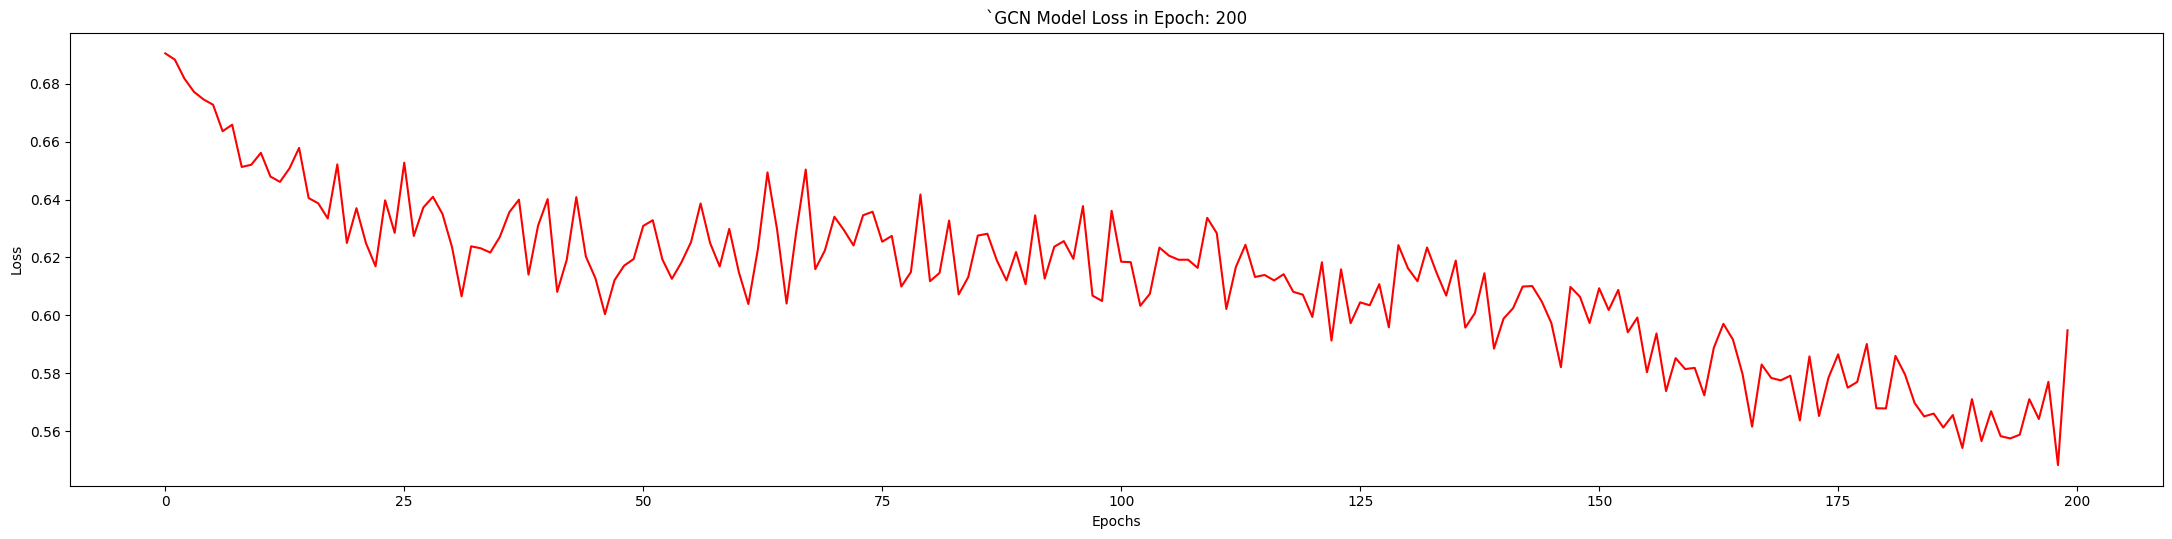

Epoch: 201, LRP Model Loss: 0.5568
Epoch: 202, LRP Model Loss: 0.5485
Epoch: 203, LRP Model Loss: 0.5546
Epoch: 204, LRP Model Loss: 0.5592
Epoch: 205, LRP Model Loss: 0.5648
Epoch: 206, LRP Model Loss: 0.5499
Epoch: 207, LRP Model Loss: 0.5635
Epoch: 208, LRP Model Loss: 0.5672
Epoch: 209, LRP Model Loss: 0.5534
Epoch: 210, LRP Model Loss: 0.5565
Epoch: 211, LRP Model Loss: 0.5719
Epoch: 212, LRP Model Loss: 0.5227
Epoch: 213, LRP Model Loss: 0.5565
Epoch: 214, LRP Model Loss: 0.5400
Epoch: 215, LRP Model Loss: 0.5671
Epoch: 216, LRP Model Loss: 0.5802
Epoch: 217, LRP Model Loss: 0.5547
Epoch: 218, LRP Model Loss: 0.5549
Epoch: 219, LRP Model Loss: 0.5488
Epoch: 220, LRP Model Loss: 0.5500
Epoch: 221, LRP Model Loss: 0.5573
Epoch: 222, LRP Model Loss: 0.5284
Epoch: 223, LRP Model Loss: 0.5708
Epoch: 224, LRP Model Loss: 0.5368
Epoch: 225, LRP Model Loss: 0.5622
Epoch: 226, LRP Model Loss: 0.5419
Epoch: 227, LRP Model Loss: 0.5490
Epoch: 228, LRP Model Loss: 0.5398
Epoch: 229, LRP Mode

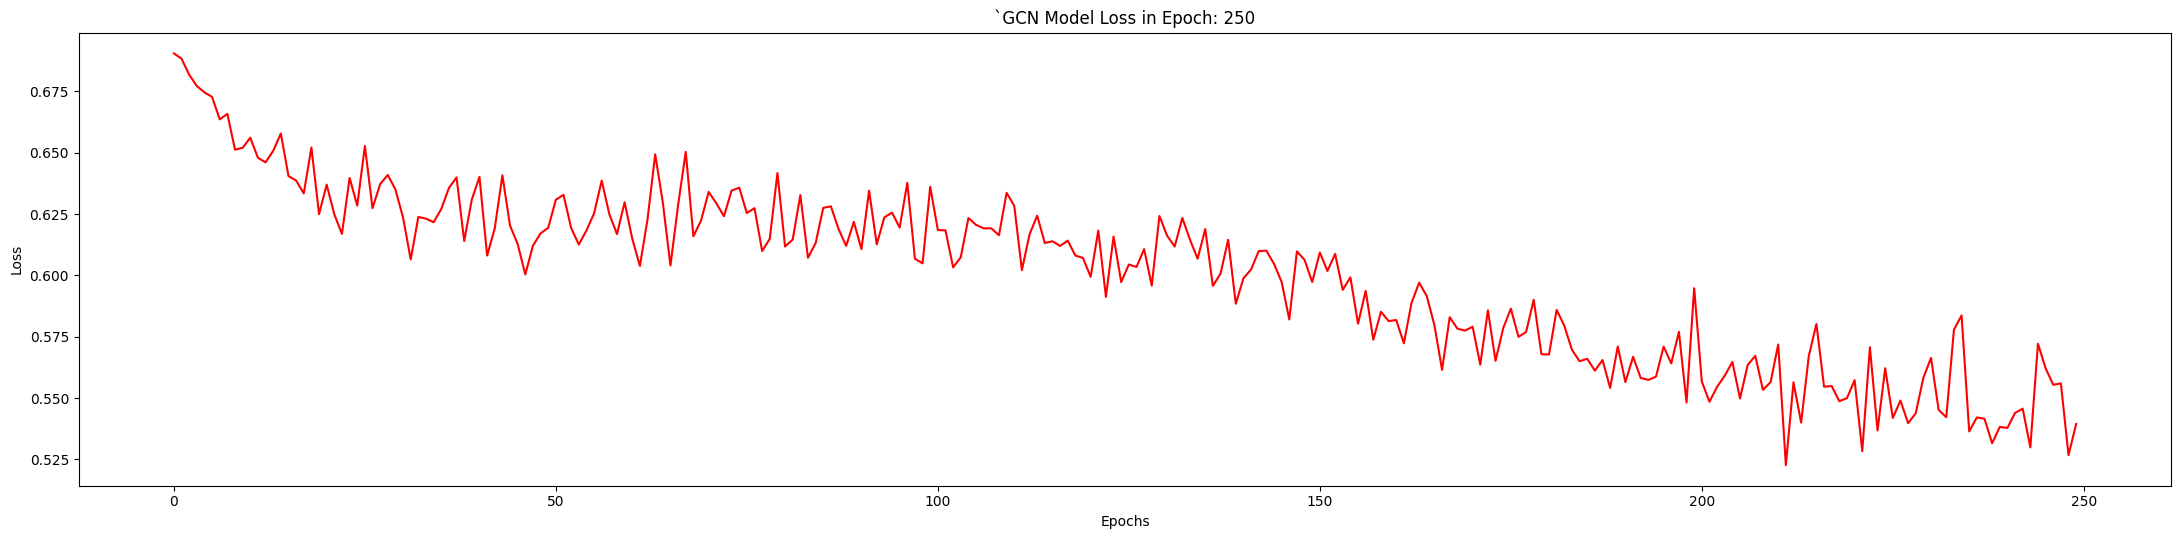

Epoch: 251, LRP Model Loss: 0.5364
Epoch: 252, LRP Model Loss: 0.5720
Epoch: 253, LRP Model Loss: 0.5664
Epoch: 254, LRP Model Loss: 0.5410
Epoch: 255, LRP Model Loss: 0.5340
Epoch: 256, LRP Model Loss: 0.5581
Epoch: 257, LRP Model Loss: 0.5545
Epoch: 258, LRP Model Loss: 0.5338
Epoch: 259, LRP Model Loss: 0.5349
Epoch: 260, LRP Model Loss: 0.5385
Epoch: 261, LRP Model Loss: 0.5538
Epoch: 262, LRP Model Loss: 0.5724
Epoch: 263, LRP Model Loss: 0.5415
Epoch: 264, LRP Model Loss: 0.5457
Epoch: 265, LRP Model Loss: 0.5285
Epoch: 266, LRP Model Loss: 0.5553
Epoch: 267, LRP Model Loss: 0.5616
Epoch: 268, LRP Model Loss: 0.5354
Epoch: 269, LRP Model Loss: 0.5351
Epoch: 270, LRP Model Loss: 0.5328
Epoch: 271, LRP Model Loss: 0.5489
Epoch: 272, LRP Model Loss: 0.5281
Epoch: 273, LRP Model Loss: 0.5556
Epoch: 274, LRP Model Loss: 0.5366
Epoch: 275, LRP Model Loss: 0.5589
Epoch: 276, LRP Model Loss: 0.5526
Epoch: 277, LRP Model Loss: 0.5168
Epoch: 278, LRP Model Loss: 0.5655
Epoch: 279, LRP Mode

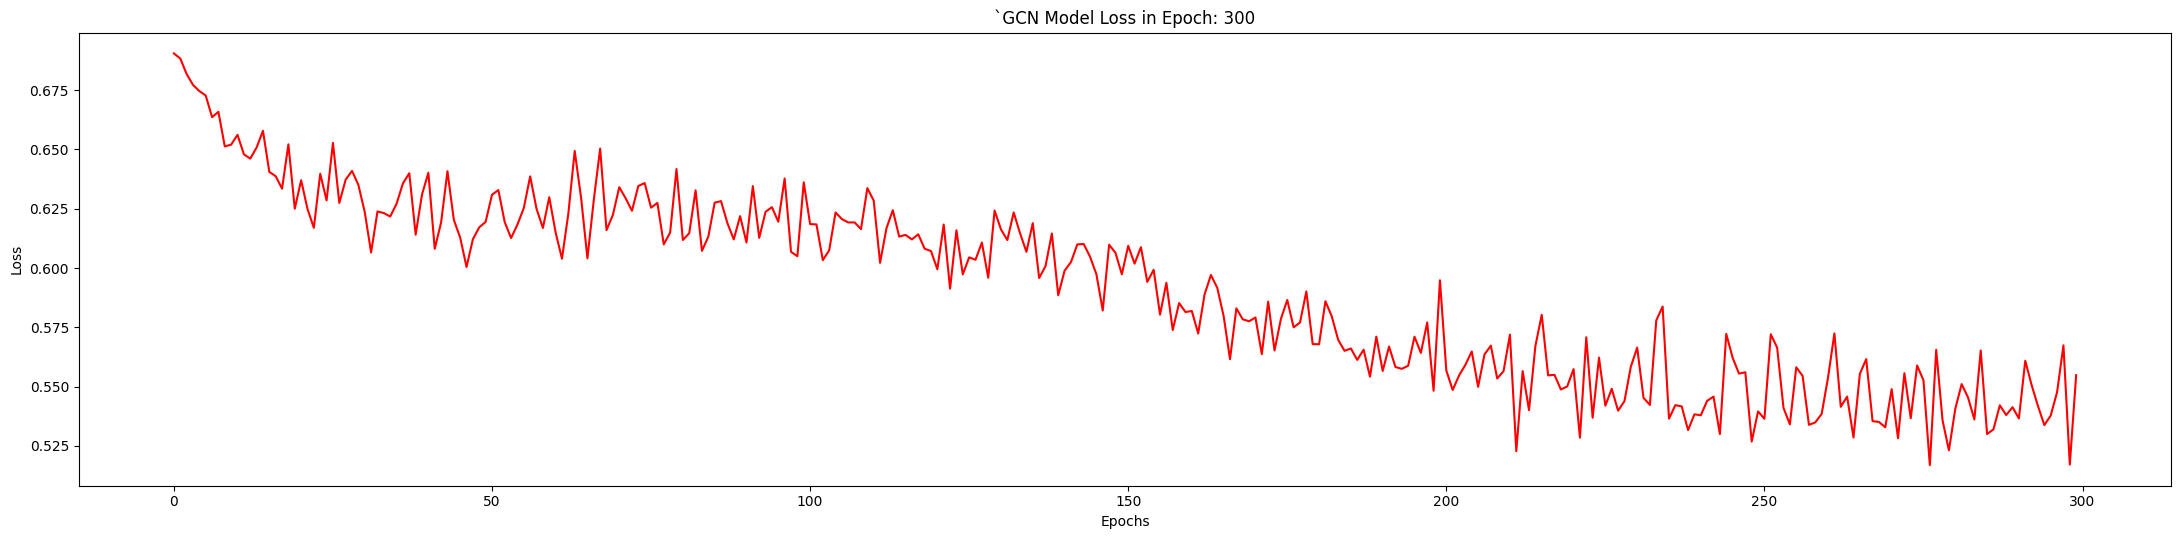

In [24]:
EPOCHS = 300
load_index = 0
if load_index != 0:
    GNN_Model, GNN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
def GNN_Model_test(test_loader):
    predictions = []
    GNN_Model.eval()

    correct = 0
    for batch_of_graphs in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft  = GNN_Model(batch_of_graphs)
        GNN_Model_test_pred = soft.argmax(dim=1)
        predictions.append(GNN_Model_test_pred)

        correct += int((GNN_Model_test_pred == batch_of_graphs.y).sum())

    return correct / len(test_loader.dataset), predictions[0].detach().tolist()

In [ ]:
GNN_Model_test_acc, predictions = GNN_Model_test(test_loader)
print(f'Test Accuracy: {GNN_Model_test_acc:.4f}')

Test Accuracy: 0.6053


In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
samples_time = instance_time(test_dataset)
print(f'Test Instance based Time: {samples_time}')

Test Instance based Time: [0.005967428000019481, 0.002129347999982656, 0.001967675000003055, 0.0017899730000294767, 0.0036397560000409612, 0.0014730499999586755, 0.0012285440000141534, 0.0012056460000167135, 0.0011668890000464671, 0.0011665270000094097, 0.00182654600001797, 0.0014209779999987404, 0.001241299000014351, 0.0012502729999823714, 0.0012571080000043366, 0.001148747000002004, 0.0013829470000246147, 0.0012209930000040004, 0.0011417829999800233, 0.001124430000004395, 0.001121759000000111, 0.0011179370000036215, 0.0011178809999705663, 0.0010937110000099892, 0.0011171900000022106, 0.0010944279999876017, 0.001088652000021284, 0.0011329320000186271, 0.0011453349999897, 0.0011127549999514486, 0.00115312799999856, 0.0011218989999974838, 0.0011274650000245856, 0.00110656999999037, 0.0011226529999817103, 0.001291530999992574, 0.001119141000003765, 0.0011217939999710325]


In [ ]:
GNN_Model.eval()

post_conv1_test, post_conv2_test, lrp_gap, GCN_Model_test_out = GNN_Model(dataset[0])


In [ ]:
print(predictions)
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print("Auc_Roc: ", Auc_Roc, "Auc_Prc: ", Auc_Prc, "Acc: ", Acc, "Acc2: ", Acc2)

Auc_Roc:  0.5386904761904762 Auc_Prc:  0.7892090139140956 Acc:  0.6052631578947368 Acc2:  23


## **Instance Specific Time**

In [25]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [26]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.01330061500004831, 0.001692284999990079, 0.0014513540000962166, 0.0012489829999822177, 0.0012819089999993594, 0.0012339840000095137, 0.0012340179999910106, 0.0012263020000773395, 0.00136461399995369, 0.0011767920000238519, 0.0011696139999912702, 0.0011446250000517466, 0.0011318110000502202, 0.0011573850000559105, 0.001168253000059849, 0.0010949740000114616, 0.001132980000079442, 0.0012365200000203913, 0.0010970280000037747, 0.0011846079999031645, 0.0011374900000191701, 0.0011524960000315332, 0.0011969779999390084, 0.0011528149999548987, 0.001131684000029054, 0.0011256200000389072, 0.0011772809999683886, 0.00120078600002671, 0.0015841800000089279, 0.001147217000038836, 0.00110107299997253, 0.0011640359999773864, 0.0011537860000316869, 0.0011129290001008485, 0.0011082580000447706, 0.001098460999969575, 0.0011650200000303812, 0.0010976049999271709]


## **LayerWise Relevence Propagation**

In [27]:
GNN_Model_state = GNN_Model.state_dict()
print(GNN_Model_state.keys())

odict_keys(['GConvs.0.bias', 'GConvs.0.lin.weight', 'GConvs.1.bias', 'GConvs.1.lin.weight', 'ffn.weight', 'ffn.bias'])


In [ ]:
print(GNN_Model.GConvs[1].lin.weight.tolist())

[[0.6481884717941284, -0.8070554733276367, -0.29886385798454285, 0.25266432762145996, 0.9467662572860718, 0.08415601402521133, 0.891517698764801], [0.3126969635486603, -1.5317621231079102, -0.18301202356815338, 0.0024455031380057335, -0.024340610951185226, 0.7762219309806824, -0.050555236637592316], [-0.30982452630996704, 0.34943345189094543, -1.4172875881195068, 1.3926091194152832, 1.128761887550354, 1.9846010208129883, 0.09655214101076126], [0.870201051235199, -0.12092108279466629, -0.28959912061691284, 0.3039678931236267, 0.5109046697616577, 0.17877866327762604, 0.8327926397323608], [-0.6857482194900513, 0.9549042582511902, -0.723865270614624, 2.0591413974761963, 0.8628089427947998, 1.6239370107650757, -0.34562307596206665], [-1.0664892196655273, 0.5399594306945801, -1.2032413482666016, 1.9572471380233765, 1.1601618528366089, 1.5170241594314575, 0.5137133598327637], [-0.8883391618728638, 0.726530909538269, -0.9229431748390198, 1.1327471733093262, -0.19153976440429688, 0.611087620258

In [41]:
def GNN_Model_LRP(test_dataset):
    FFN_activations = []
    GConv2_activations = []
    GConv1_activations = []

    GNN_Model.eval()

    for batch_of_graphs in test_dataset:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batch_of_graphs)
        GConv1_activations.append(Output_of_Hidden_Layers[0])
        GConv2_activations.append(Output_of_Hidden_Layers[1])
        FFN_activations.append(ffn_output)

    return GConv1_activations, GConv2_activations, FFN_activations

In [42]:
GConv1_activations_torch, GConv2_activations_torch, FFN_activations_torch  = GNN_Model_LRP(test_dataset)

In [43]:
GConv1_activations_torch, GConv2_activations_torch, FFN_activations_torch  = GNN_Model_LRP(test_dataset)
#print(FFN_activations_torch)
FFN_activations = []
for tens in FFN_activations_torch:
    FFN_activations.append(torch.squeeze(tens).tolist())
    #print(tens)
#print(FFN_activations)

GConv2_activations = []
for tens in GConv2_activations_torch:
    GConv2_activations.append(torch.squeeze(tens).tolist())

GConv1_activations = []
for tens in GConv1_activations_torch:
    GConv1_activations.append(torch.squeeze(tens).tolist())

In [44]:
print("FFN_activations")
print(len(FFN_activations_torch))
print(FFN_activations_torch[0].size())

print(FFN_activations_torch)
print("GConv1_activations")
print(len(GConv1_activations_torch))
print(GConv1_activations_torch[0].size())
print()
print("GConv2_activations")
print(len(GConv2_activations_torch))
print(GConv2_activations_torch[0].size())

FFN_activations
38
torch.Size([1, 2])
[tensor([[-0.6896,  3.1334]], grad_fn=<EluBackward0>), tensor([[-0.0259,  1.4414]], grad_fn=<EluBackward0>), tensor([[-0.0183,  1.4324]], grad_fn=<EluBackward0>), tensor([[ 1.0159, -0.0970]], grad_fn=<EluBackward0>), tensor([[-0.5774,  2.6895]], grad_fn=<EluBackward0>), tensor([[-0.4053,  2.1875]], grad_fn=<EluBackward0>), tensor([[-0.4732,  2.3207]], grad_fn=<EluBackward0>), tensor([[-0.6160,  2.8051]], grad_fn=<EluBackward0>), tensor([[-0.6903,  3.1368]], grad_fn=<EluBackward0>), tensor([[-0.6456,  2.9304]], grad_fn=<EluBackward0>), tensor([[0.6690, 0.3144]], grad_fn=<EluBackward0>), tensor([[0.2578, 0.9437]], grad_fn=<EluBackward0>), tensor([[0.5665, 0.4559]], grad_fn=<EluBackward0>), tensor([[-0.6697,  3.0378]], grad_fn=<EluBackward0>), tensor([[-0.7611,  3.5349]], grad_fn=<EluBackward0>), tensor([[0.7303, 0.3948]], grad_fn=<EluBackward0>), tensor([[-0.6670,  3.0249]], grad_fn=<EluBackward0>), tensor([[-0.1372,  1.5643]], grad_fn=<EluBackward0>

In [ ]:
print(len(GConv1_activations))
print(len(GConv1_activations[0]))

38
17


In [34]:
def accumulate_weights(model_for_you):

    #gconv1_bias = model_for_you.gconv1.bias.detach().tolist()
    gconv1_weight = model_for_you.GConvs[0].lin.weight.detach().tolist()

    #gconv2_bias = model_for_you.gconv2.bias.detach().tolist()
    gconv2_weight = model_for_you.GConvs[1].lin.weight.detach().tolist()

    #ffn_bias = model_for_you.ffn.bias.detach().tolist()
    ffn_weight = model_for_you.ffn.weight.detach().tolist()



    #return gconv1_weight, gconv1_bias, gconv2_weight, gconv2_bias, ffn_weight, ffn_bias
    return gconv1_weight, gconv2_weight, ffn_weight

In [35]:
GConv1_weight, GConv2_weight, FFN_weight = accumulate_weights(GNN_Model)

In [36]:
GConv1_weight_T = np.array(GConv1_weight).transpose()
GConv1_weight_T = GConv1_weight_T.tolist()
print(np.shape(GConv1_weight_T))


(7, 7)


In [37]:
GConv2_weight_T = np.array(GConv2_weight).transpose()
GConv2_weight_T = GConv2_weight_T.tolist()
print(np.shape(GConv2_weight_T))


(7, 7)


In [38]:
FFN_weight_T = np.array(FFN_weight).transpose()
FFN_weight_T = FFN_weight_T.tolist()
print(np.shape(FFN_weight_T))

(7, 2)


In [39]:
GConv1_weight = GConv1_weight.copy()
GConv2_weight = GConv2_weight.copy()
FFN_weight = FFN_weight.copy()

In [ ]:
a = np.array([[1., 2.], [3., 4.], [5, 6]])
print(a)


b=a[::-1]
print(b)


[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[5. 6.]
 [3. 4.]
 [1. 2.]]


In [29]:
def my_relu(input):
    return np.maximum(0, input)
print(my_relu([0,1,2,3,4,-1,-2,-4,-6]))
print(my_relu(-1))

ls = [1,2,2,2,2,2,2]
z = [0] * len(ls)
print(z)

[0 1 2 3 4 0 0 0 0]
0
[0, 0, 0, 0, 0, 0, 0]


In [28]:
def Compute_R_K(FFN_activations, wrt):
    #print("before FFN_activations",FFN_activations)
    #FFN_activations = torch.squeeze(FFN_activations).tolist()
    #print("after FFN_activations", FFN_activations)
    #FFN_activations = FFN_activations[0]
    if wrt == 2:  #.     Graph Label
        last_layer_R_k = [0] * len(FFN_activations)
        last_layer_R_k[FFN_activations.index(max(FFN_activations))] = FFN_activations[FFN_activations.index(max(FFN_activations))]
        #print(last_layer_R_k)
        return last_layer_R_k
    elif wrt == 0: #.    Class 0
        last_layer_R_k = [0] * len(FFN_activations)
        last_layer_R_k[0] = FFN_activations[0]
        #print(last_layer_R_k)
        return last_layer_R_k
    elif wrt == 1: #.    Class 1
        last_layer_R_k = [0] * len(FFN_activations)
        last_layer_R_k[1] = FFN_activations[1]
        #print(last_layer_R_k)
        return last_layer_R_k

In [30]:
def Compute_R_J(epsilon, preceding_layer_activations, exceding_layer_weights, next_layer_R_k, is_it_last):
    #print("preceding_layer_activations: ", len(preceding_layer_activations))
    #print("preceding_layer_activations[0]: ", len(preceding_layer_activations[0]))

    Denominators = []
    for i in range(len(preceding_layer_activations)):
        Denominators_Node = []
        for j in range(len(preceding_layer_activations[i])):
            SUM_Denominator = 0
            for k in range(len(exceding_layer_weights[j])):
                SUM_Denominator = SUM_Denominator + preceding_layer_activations[i][j] * my_relu(
                    exceding_layer_weights[j][k])
            Denominators_Node.append(epsilon + SUM_Denominator)
        Denominators.append(Denominators_Node)
    #print("Denominator is done: ", Denominators)
    #print("Denominator Length: ", len(Denominators))

    if is_it_last:
        Numerators = []
        for i in range(len(preceding_layer_activations)):
            Node_Numerator = []
            for j in range(len(preceding_layer_activations[i])):
                SUM_Nominator = 0
                for k in range(len(exceding_layer_weights[j])):
                    SUM_Nominator = SUM_Nominator + preceding_layer_activations[i][j] * my_relu(
                        exceding_layer_weights[j][k]) * next_layer_R_k[k]
                    # print(next_layer_R_k[k])
                Node_Numerator.append(SUM_Nominator)
            Numerators.append(Node_Numerator)
    else:
        Numerators = []
        for i in range(len(preceding_layer_activations)):
            Node_Numerator = []
            for j in range(len(preceding_layer_activations[i])):
                SUM_Nominator = 0
                for k in range(len(exceding_layer_weights[j])):
                    SUM_Nominator = SUM_Nominator + preceding_layer_activations[i][j] * my_relu(
                        exceding_layer_weights[j][k]) * next_layer_R_k[i][k]
                Node_Numerator.append(SUM_Nominator)
            Numerators.append(Node_Numerator)

    R_Js_Graph = []
    for i in range(len(Numerators)):
        R_Js_Graph.append([sum(x) / sum(Denominators[i]) for x in Numerators])

    return R_Js_Graph

In [31]:
def One_Graph_LRP(epsilon, wrt, graph_sample, weights, activations):
    GConv1_weight = weights[0]
    GConv1_weight_T = weights[1]

    GConv2_weight = weights[2]
    GConv2_weight_T = weights[3]

    FFN_weight = weights[4]
    FFN_weight_T = weights[5]

    GConv1_activations = activations[0]
    GConv2_activations = activations[1]
    FFN_activations = activations[2]

    last_layer_R_k = Compute_R_K(FFN_activations, wrt)
    #print("R_K: ",last_layer_R_k)
    R_J_hidden2 = Compute_R_J(epsilon, GConv2_activations, FFN_weight_T, last_layer_R_k, True)
    #print(R_J_hidden2)
    #print(len(R_J_hidden2))
    R_J_hidden1 = Compute_R_J(epsilon, GConv1_activations, GConv2_weight, R_J_hidden2, False)
    #print(R_J_hidden1)
    #print(len(R_J_hidden1))
    R_J_input = Compute_R_J(epsilon, graph_sample, GConv1_weight, R_J_hidden1, False)
    #print(R_J_input)
    #print(len(R_J_input))


    return R_J_input

In [ ]:
print(np.shape(GConv1_weight), np.shape(GConv2_weight), np.shape(FFN_weight_T))
print(np.shape(GConv1_weight_T), np.shape(GConv2_weight_T), np.shape(FFN_weight))

(7, 7) (7, 7) (7, 2)
(7, 7) (7, 7) (2, 7)


In [ ]:
print(np.shape(dataset[0].x.detach().tolist()))

(17, 7)


In [ ]:
print(np.shape(dataset[0].x[0]), np.shape(GConv1_activations), np.shape(GConv2_activations), np.shape(FFN_activations))

torch.Size([7]) (38,) (38,) (38, 2)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
print(len(test_dataset[0].x))
print(test_dataset[0])

17
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [32]:
from numpy import exp
x = torch.rand(1,10)
def softmax(vector):
    e = exp(vector)
    return e / e.sum()
print(x)
print(softmax(x))

tensor([[0.3385, 0.9890, 0.4888, 0.1711, 0.0872, 0.9011, 0.4357, 0.4546, 0.1784,
         0.2581]])
tensor([[0.0873, 0.1673, 0.1014, 0.0738, 0.0679, 0.1532, 0.0962, 0.0980, 0.0744,
         0.0805]])


In [45]:
Graph_Sample = 0
epsilon = 1e-16
wrt = 0
LRP = One_Graph_LRP(epsilon, wrt, test_dataset[Graph_Sample].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[Graph_Sample], GConv2_activations[Graph_Sample], FFN_activations[Graph_Sample]])

In [46]:
print(softmax(LRP[0]))

[0.06259755 0.06259755 0.06276212 0.06246789 0.06234864 0.06276212
 0.06276212 0.06276212 0.06234864 0.06246789 0.06276212 0.06276212
 0.06541731 0.06294522 0.03129521 0.04447071 0.04447071]


## **LRPs for all test graphs**

In [71]:
LRPs_Testset = []
epsilon = 1e-16
wrt = 0
for i in range(len(test_dataset)):
    LRPs_Testset.append(One_Graph_LRP(epsilon, wrt, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))

In [48]:
print(np.shape(LRPs_Testset[0]))

(17, 17)


In [85]:
t1 = perf_counter()
wrt = 0
LRPs_Testset0 = []
epsilon = 1e-16
for i in range(len(test_dataset)):
    LRPs_Testset0.append(One_Graph_LRP(epsilon, wrt, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))

wrt = 1
LRPs_Testset1 = []
epsilon = 1e-16
for i in range(len(test_dataset)):
    LRPs_Testset1.append(One_Graph_LRP(epsilon, wrt, test_dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))
consumed_time = perf_counter() - t1
print("consumed_time: ",consumed_time/(2*(len(test_dataset))))

consumed_time:  0.01268114347368809


In [75]:
class0 = [list(np.sum(graph, axis=1)) for graph in LRPs_Testset0]
class1 = [list(np.sum(graph, axis=1)) for graph in LRPs_Testset1]

In [72]:
print(len(LRPs_Testset[0]))
print(len(LRPs_Testset[0][0]))
LRPs_Testset = [list(np.sum(graph, axis=1)) for graph in LRPs_Testset]
print(len(LRPs_Testset[0]))
print(LRPs_Testset)

17
17
17
[[-0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.46445157928116493, -0.21775518616317502, -0.19493587378312316, -0.19493587378312316], [-0.0001505614197744253, -0.0001505614197744253, -0.0001505614197744253, -0.0001505614197744253, -0.0001505614197744253, -0.0001505614197744253, -7.058976964340231e-05, -0.0001505614197744253, -0.0001505614197744253, -0.0001505614197744253, -7.058976964340231e-05, -6.319242571460333e-05, -6.319242571460333e-05], [-1.3061279762072858e-06, -1.3061279762072858e-06, -1.3061279762072858e-06, -1.3061279762072858e-06, -1.3061279762072858e-06, -1.3061279762072858e-06, -1.3061279762072858e-06, -6.12369842841777e-07, -1.3061279762072858e-06, -1.3061279762072858e-06, -6.12369842841777e-07, -5.481975079275024e-07, -5.4

In [76]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [79]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(a_trained_model=GNN_Model,
                                                                               test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=class0, saliency_class1=class1, importance_threshold=0.01,
                                               style="Node")
print(fid_score2)

0.029761904761904767


In [80]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [81]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP",
                                                                                            a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, class0,
                                                                     class1, importance_threshold=0.5,
                                                                     contrast_coeff=1)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5103547486601008


In [82]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [83]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, class0, class1, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.6302282920514105


## **Normalize LRPs**

In [49]:
from numpy import exp
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

def normalize_values(LRP_attribution_scores):
    Normalized_LRP_attribution_scores = []
    for graph_lrps in LRP_attribution_scores:
        new_lrps = []
        for dim in graph_lrps:
            new_lrps.append(((dim-min(graph_lrps))*normalize_coeff)/(max(graph_lrps)-min(graph_lrps)))
        Normalized_LRP_attribution_scores.append(new_lrps)
    return Normalized_LRP_attribution_scores

def Normalize_LRPs(dataset,wrt):

    LRPs_Testset = []
    for i in range(len(dataset)):
        LRPs_Testset.append(One_Graph_LRP(epsilon, wrt, dataset[i].x.detach().tolist(), [GConv1_weight, GConv1_weight_T, GConv2_weight, GConv2_weight_T, FFN_weight, FFN_weight_T], [GConv1_activations[i], GConv2_activations[i], FFN_activations[i]]))
    #print("LRPs_Testset: ", np.shape(LRPs_Testset[0]))
    LRPs_Testset = [np.sum(graph, axis=1) for graph in LRPs_Testset]
    Normalized_LRP_attribution_scores = normalize_values(LRPs_Testset)
    #print("Normalized_LRP_attribution_scores: ", Normalized_LRP_attribution_scores)
    Normalized_LRPs = []
    for i in range(len(Normalized_LRP_attribution_scores)):
        graph_norms = []
        for j in range(len(Normalized_LRP_attribution_scores[i])):
            graph_norms.append(Normalized_LRP_attribution_scores[i][j]/max(Normalized_LRP_attribution_scores[i]))
        Normalized_LRPs.append(graph_norms)
    return Normalized_LRPs

In [50]:
norm_lrps = Normalize_LRPs(test_dataset, 1)

In [51]:
print(norm_lrps)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9153321609296063, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9153321609296071, 0.0, 0.0, 0.0, 0.9153321609296071, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.08466783907039681, 1.0, 1.0, 0.08466783907039681, 0.0, 0.0], [0.0, 0.0, 0.0, 0.9153321609296063, 0.0, 0.9153321609296063, 0.0, 0.0, 0.0, 0.9153321609296063, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9153321609296069, 0.9153321609296069, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8658029070050716, 0.9458893109641932, 0.9458893109641932, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9153321609296065, 1.0, 1.0, 0.9153321609296065, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9153321609296065, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9153321609296067, 1.0, 1.0],

## **Fiedelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []


    your_model.eval()
    for batched_data in your_dataset:
        post_conv1, post_conv2, lrp_gap, out = your_model(batched_data)
        #logits = F.log_softmax(out, dim=1)
        #prob = F.softmax(logits, dim=1)

        preds.append(out.cpu().detach())

    for i in range(len(your_dataset)):
        reals.append(your_dataset[i].y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)


    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc

In [ ]:
def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

In [ ]:
def drop_important_nodes(your_dataset, importance_range, wrt):
    LRP_attribution_scores = Normalize_LRPs(test_dataset, wrt)
    occluded_GNNgraph_list = []

    for i in range(len(LRP_attribution_scores)):
        sample_graph = deepcopy(your_dataset[i].detach())
        for j in range(len(sample_graph.x)):
            if is_salient((LRP_attribution_scores[i][j]), importance_range):
                #print("before: ", sample_graph.x[j])
                sample_graph.x[j][:] = 0
                #print(torch.zeros_like(sample_graph.x[j]))
                #print("manipulated: ",sample_graph.x[j])
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, importance_range):

    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset = drop_important_nodes(your_dataset, importance_range, wrt)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

## **Contrastivity**

In [ ]:
def binarize_scores(dataset, wrt, importance_threshold):
    LRP_attribution_scores = Normalize_LRPs(dataset, wrt)
    binarized_attribution_scores_list = []
    for graph_scores in LRP_attribution_scores:
        binary_score = ''
        for node_scores in graph_scores:
            if is_salient(node_scores, importance_threshold):
                binary_score += '1'
            else:
                binary_score += '0'
        binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

In [ ]:
def compute_contrastivity(dataset, importance_range):
    binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_range)
    binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_range)
    print("binarized_salient_nodes_for_class0: ", binarized_salient_nodes_for_class0)
    print("binarized_salient_nodes_for_class1: ", binarized_salient_nodes_for_class1)

    result_list = []
    # Calculate hamming distance
    for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
        #assert len(class_0) == len(class_1)
        d = hamming_distance(class_0, class_1)/len(class_0)
        result_list.append(d)

    return mean(result_list)

## **Sparsity**

In [ ]:
def binarize_nodes(dataset, importance_range):
    #binarized_salient_nodes_for_graph = binarize_scores(dataset, 2, importance_range)
    #binarized_salient_nodes_for_class0 = binarize_scores(dataset, 0, importance_range)
    #binarized_salient_nodes_for_class1 = binarize_scores(dataset, 1, importance_range)
    LRP_attribution_scores_class0 = Normalize_LRPs(dataset, 0)
    LRP_attribution_scores_class1 = Normalize_LRPs(dataset, 1)

    class_0_salient_nodes = []
    class_1_salient_nodes = []
    salient_nodes_preds = []

    for i in range(len(LRP_attribution_scores_class0)):
        class_0_graph = []
        for j in range(len(LRP_attribution_scores_class0[i])):
            class_0_node = []
            if is_salient((LRP_attribution_scores_class0[i][j]), importance_range):
                class_0_node.append(1)
            else:
                class_0_node.append(0)
            class_0_graph.append(class_0_node)
        class_0_salient_nodes.append(class_0_graph)

    for i in range(len(LRP_attribution_scores_class1)):
        class_1_graph = []
        for j in range(len(LRP_attribution_scores_class1[i])):
            class_1_node = []
            if is_salient((LRP_attribution_scores_class1[i][j]), importance_range):
                class_1_node.append(1)
            else:
                class_1_node.append(0)
            class_1_graph.append(class_1_node)
        class_1_salient_nodes.append(class_1_graph)


    return class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
    #print("salient_list: ", salient_list)
    summed = 0
    for sl in salient_list:
        summed = summed + sum(sl)
    return summed

In [ ]:
def compute_sparsity(dataset, importance_range):
    class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(dataset, importance_range)
    #print(salient_nodes_graph)
    #print(class_0_salient_nodes)
    #print(class_1_salient_nodes)
    sparsity_list = []
    for i in range(len(class_0_salient_nodes)):
        d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
        d = d / (len(class_0_salient_nodes[i]) * 2)
        sparsity_list.append(1 - d)
    return mean(sparsity_list)

In [ ]:
def go_to_evaluations(your_model, dataset, importance_range):
    start_generation = perf_counter()
    norm_lrps = Normalize_LRPs(dataset, 2)
    time_consumption = perf_counter() - start_generation

    fid_LRP_label = Fidelity(your_model, dataset, importance_range)
    #print("fid_LRP_label: ", fid_LRP_label)

    contrastivity_with_LRP = compute_contrastivity(dataset, importance_range)
    #print("contrastivity_with_LRP: ", contrastivity_with_LRP)

    sparsity_with_LRP = compute_sparsity(dataset, importance_range)
    #print("sparsity_with_LRP: ", sparsity_with_LRP)


    #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #  wr.writerow([str(Explainability_name), "MUTAG", fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption])
    #task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods for SoftWare.csv", 'a') as outcsv:
    #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #  wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, LRP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption, mean(LRP_Model_training_time_per_epoch), times])


    return fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption

## **Get Metrics**

In [ ]:
fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, time_consumption = go_to_evaluations(GNN_Model, test_dataset, 0.5)
print("fid_LRP_label: ", fid_LRP_label)
print("contrastivity_with_LRP: ", contrastivity_with_LRP)
print("sparsity_with_LRP: ", sparsity_with_LRP)
print("time_consumption: ", time_consumption/len(test_dataset))
#go_to_evaluations(GNN_Model, test_dataset, 0.1)

binarized_salient_nodes_for_class0:  ['11111111111111011', '1111110111011', '1111111011011', '000101000100', '11111111111111110011', '11111101111111111', '1111111111111111011011', '11111111111011', '11111111111111011', '111111111111011', '111111011011', '111111111111011011011', '11111111100111111011011', '1111111111111011', '11111111111111111111011', '0000001000', '1111111111111011', '0000000000000000100100100', '1111011111111011', '11111111111111111111011', '1111011111011', '1111110111111011', '11111111111111011011011011', '00000000010010100', '111111111111011', '111111011111', '000000000000100100100', '0000000000000000100', '0110000000100', '0000000000100100', '1111110111111011', '110110111011', '111100111011', '000000100100', '11101111111111111011', '1111110110111', '0110000000100', '1111111111111111011011']
binarized_salient_nodes_for_class1:  ['00000000000000100', '0000001000100', '0000000100100', '000101000100', '00000000000000001100', '00000010000000000', '0000000000000000100100

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
print("here, ", df.loc[4, 'Explicability Method Name'])
df.loc[4, 'Fidelity'] = fid_LRP_label
df.loc[4, 'Contrastivity'] = contrastivity_with_LRP
df.loc[4, 'Sparsity'] = sparsity_with_LRP
df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


here,  LRP


In [ ]:
attribution_time = time_consumption/len(test_dataset)

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
l = [Explainability_name, task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, LRP_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_LRP_label, contrastivity_with_LRP, sparsity_with_LRP, attribution_time, statistics.mean(LRP_Model_training_time_per_epoch), samples_time]

In [ ]:
task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow(l)

In [ ]:
def LRP_Relevance_Graph_Features(LRP, sample):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Node Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("LRP generated for sample Graph: " + str(sample) + "where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax1.plot(LRP, color='r')
  print('done')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "LRP generated for sample number: " + str(sample) + ".png")
  plt.show()

(7,)
done


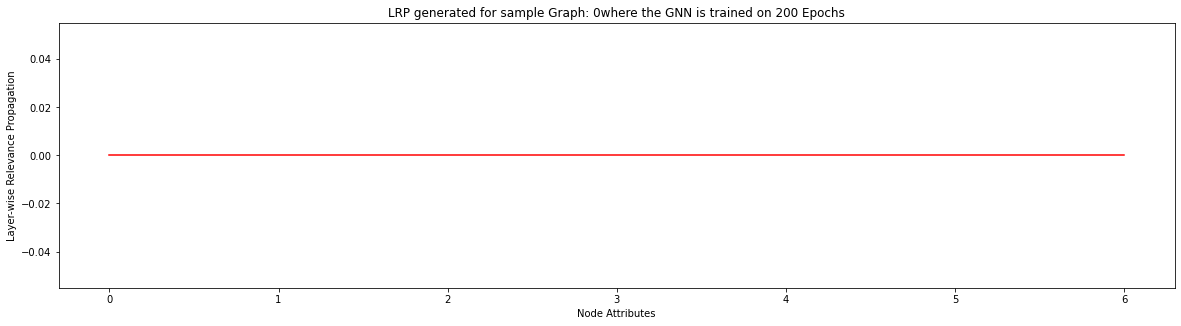

In [ ]:
Averaged_LRP = np.mean(LRP, axis=0)
print(np.shape(Averaged_LRP))
LRP_Relevance_Graph_Features(Averaged_LRP, 0)

## **Relevances of Graphs in each Class**

In [ ]:
Graph_Index_Class1 = []
Graph_Index_Class2 = []

In [ ]:
for i in range(len(test_dataset)):
  if test_dataset[i].y == 0:
    Graph_Index_Class1.append(i)
  else:
    Graph_Index_Class2.append(i)

In [ ]:
print(len(Graph_Index_Class1), len(Graph_Index_Class2))
print(Graph_Index_Class1)
print(Graph_Index_Class2)

24 33
[4, 5, 6, 7, 12, 16, 21, 25, 26, 28, 29, 30, 31, 33, 36, 37, 39, 42, 50, 52, 53, 54, 55, 56]
[0, 1, 2, 3, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 27, 32, 34, 35, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51]


In [ ]:
LRPs_Class1 = []
LRPs_Class2 = []

## **LRP of Graphs in each Class**

In [ ]:
for index in Graph_Index_Class1:
  LRPs_Class1.append(LRPs_Testset[index])
for index in Graph_Index_Class2:
  LRPs_Class2.append(LRPs_Testset[index])

In [ ]:
print(len(LRPs_Class1[1]))
print(len(LRPs_Class2))


11
33


## **Averaged Relevances on Node Features in all Graphs**

In [ ]:
LRPs_Class1_Averaged_on_Nodes = []
LRPs_Class2_Averaged_on_Nodes = []
for graph in LRPs_Class1:
  LRPs_Class1_Averaged_on_Nodes.append(np.mean(graph, axis=0))

for graph in LRPs_Class2:
  LRPs_Class2_Averaged_on_Nodes.append(np.mean(graph, axis=0))

In [ ]:
print(len(LRPs_Class1_Averaged_on_Nodes))
print(len(LRPs_Class2_Averaged_on_Nodes))

24
33


## **Averaged Relevances on Graphs in each Class**

In [ ]:
LRPs_Class1_Averaged_on_Graphs = []
LRPs_Class2_Averaged_on_Graphs = []
LRPs_Class1_Averaged_on_Graphs = np.mean(LRPs_Class1_Averaged_on_Nodes, axis=0)
LRPs_Class2_Averaged_on_Graphs = np.mean(LRPs_Class2_Averaged_on_Nodes, axis=0)

## **PLOT Average Relevances**

In [ ]:
def Averaged_LRP_Relevance_Classes(LRP):
  fig1 = plt.figure(figsize=(20,40))

  ax1 = plt.subplot2grid((7, 1), (0, 0), colspan=7)
  plt.xlabel("Avg Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: One, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax2 = plt.subplot2grid((7, 1), (1, 0), colspan=7)
  plt.xlabel("Avg Nodes' Attributes")
  plt.ylabel('Layer-wise Relevance Propagation')
  plt.title("Dimensionally Averaged LRPs for Class: Two, where the GNN is trained on " + str(EPOCHS) + " Epochs")

  ax1.plot(LRP[0], color='r')
  ax2.plot(LRP[1], color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Dimensionally Averaged LRPs for Classes.png")
  plt.show()

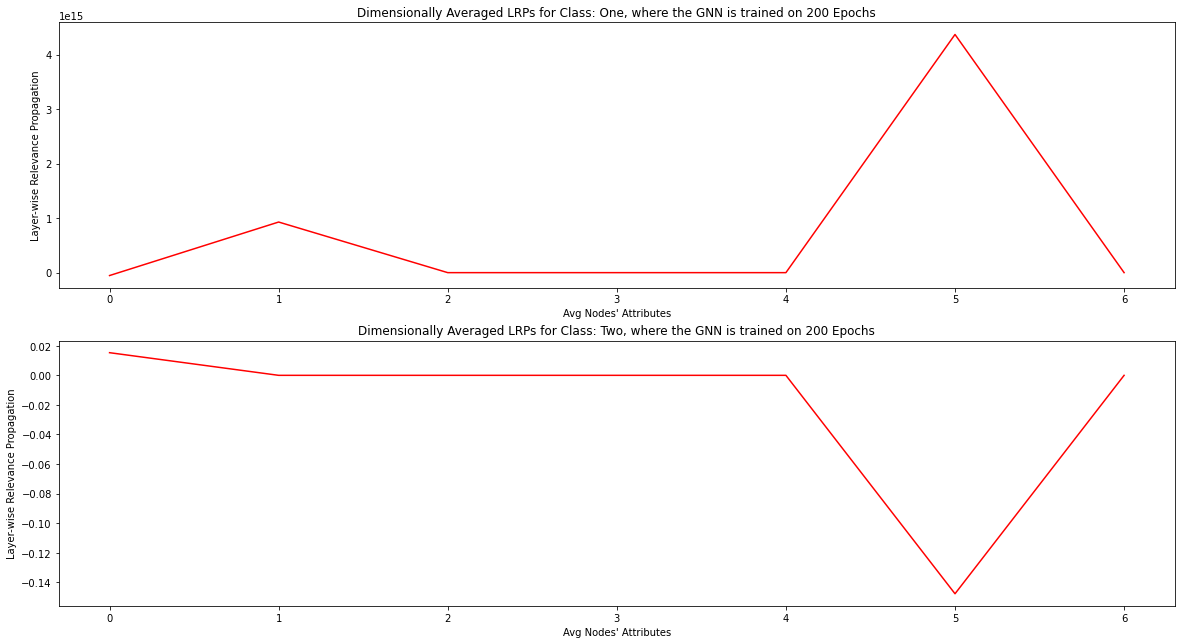

In [ ]:
Averaged_LRP_Relevance_Classes([LRPs_Class1_Averaged_on_Graphs, LRPs_Class2_Averaged_on_Graphs])